In [82]:
import csv
import matplotlib.pyplot as plt

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

# https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#:~:text=The%20full%20GEOID%20for%20many,codes%2C%20in%20which%20they%20nest.
counties = pd.read_csv('data/2020_Gaz_tracts_national.txt', delimiter='\t', dtype={'GEOID': str}).reindex()
counties.columns = [c.strip() for c in counties.columns.to_list()]
counties['FIPS_COUNTY'] = counties['GEOID'].apply(lambda x: x[:5])
counties = counties[['FIPS_COUNTY', 'GEOID', 'INTPTLAT', 'INTPTLONG']].reindex()
counties.FIPS_COUNTY.unique()
counties = counties.drop(columns=['GEOID']).groupby('FIPS_COUNTY').agg('mean').reset_index()

In [18]:
food = pd.read_csv('data/census_december_2019-food-security.csv', encoding='ISO-8859-1',
                   dtype={'GTCBSAST': np.str, 'GTMETSTA': np.str, 'GTINDVPC': np.str, 'GCFIP': np.str, 'GCTCO': np.str,
                          'GCTCB': np.str})
food.columns.to_list()


def find_col(s):
    return list(filter(lambda x: s.lower() in x.lower(), food.columns))


find_col('hrint')
print(f"columns: {food.columns.to_list()}\ncount: {food.size}")

<ipython-input-18-cdf5ea0d9651>:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype={'GTCBSAST': np.str, 'GTMETSTA': np.str, 'GTINDVPC': np.str, 'GCFIP': np.str, 'GCTCO': np.str,
<ipython-input-18-cdf5ea0d9651>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'GCTCB': np.str})


columns: ['HRHHID', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HULANGCODE', 'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL', 'HEPHONEO', 'HEFAMINC', 'HUTYPEA', 'HUTYPB', 'HUTYPC', 'HWHHWGT', 'HRINTSTA', 'HRNUMHOU', 'HRHTYPE', 'HRMIS', 'HUINTTYP', 'HUPRSCNT', 'HRLONGLK', 'HRHHID2', 'HWHHWTLN', 'FILLER', 'HUBUS', 'HUBUSL1', 'HUBUSL2', 'HUBUSL3', 'HUBUSL4', 'GEREG', 'GEDIV', 'GCFIP', 'GCTCB', 'GCTCO', 'GTCBSAST', 'GTMETSTA', 'GTINDVPC', 'GTCBSASZ', 'GCTCS', 'PERRP', 'PEPARENT', 'PRTAGE', 'PRTFAGE', 'PEMARITL', 'PESPOUSE', 'PESEX', 'PEAFEVER', 'PEAFNOW', 'PEEDUCA', 'PTDTRACE', 'PRDTHSP', 'PUCHINHH', 'PULINENO', 'PRFAMNUM', 'PRFAMREL', 'PRFAMTYP', 'PEHSPNON', 'PRMARSTA', 'PRPERTYP', 'PENATVTY', 'PEMNTVTY', 'PEFNTVTY', 'PRCITSHP', 'PRCITFLG', 'PRINUYER', 'PUSLFPRX', 'PEMLR', 'PUWK', 'PUBUS1', 'PUBUS2OT', 'PUBUSCK1', 'PUBUSCK2', 'PUBUSCK3', 'PUBUSCK4', 'PURETOT', 'PUDIS', 'PERET1', 'PUDIS1', 'PUDIS2', 'PUABSOT', 'PULAY', 'PEABSRSN', 'PEABSPDO', 'PEMJOT', 'PEMJNUM', 'PEHRUSL1', 'PEHRUSL2', '

In [19]:
food = food[food['HRINTSTA'] == 1]  # get rid of non-interview results
food = food.drop(columns=find_col('px'))  # drop 'allocation flag' columns
food.size

48352120

### HRFS12M1
indicates total household food security status
values:
- 1: secure
- 2: Low security
- 3: very low security
- -9: no response

### HRFS12MC
indicates food security status of children in the household
values:
- 1: children are food secure
- 2: low child food security
- 3: very low child food security
- -9: no response

### HRFS12M8
indicates food security status of adults in the household
values:
- 1: adults are food secure
- 2: low adult food security
- 3: very low adult food security
- -9: no response

In [20]:
geo_cols = ['GCFIP', 'GCTCO', 'FIPS_COUNTY']  # GCTCB is mislabeled in the doc as GCTCBSA
food_cols = ['HRFS12M1', 'HRFS12MC', 'HRFS12M8']
id_cols = ['QSTNUM']

# throw out records with no county code
food = food[food.GCTCO != '000']
food['FIPS_COUNTY'] = food.GCFIP + food.GCTCO

food.groupby(['FIPS_COUNTY']).agg('count')

,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HULANGCODE,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,HRFS30D1,HRFS30D2,HRFS30D3,HRFS30D4,HRFS30D5,HRFS30D6,HRFS30D7,HRFS30D8,HRFS30D9,HRFS30DE
FIPS_COUNTY,,,,,,,,,,,,,,,,,,,,,
01003,165,165,165,165,165,165,165,165,165,165,...,165,165,165,165,165,165,165,165,165,165
01081,134,134,134,134,134,134,134,134,134,134,...,134,134,134,134,134,134,134,134,134,134
01097,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
04013,1231,1231,1231,1231,1231,1231,1231,1231,1231,1231,...,1231,1231,1231,1231,1231,1231,1231,1231,1231,1231
04019,280,280,280,280,280,280,280,280,280,280,...,280,280,280,280,280,280,280,280,280,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55059,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
55073,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
55101,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80


In [21]:
summary = food.loc[:, id_cols + food_cols + geo_cols]
summary = summary.loc[summary['HRFS12M1'] > 0]

statuses = {-9: 'no response', -1: 'unknown', 1: 'secure', 2: 'insecure', 3: 'very_insecure'}
statuses_adult = {-9: 'no response', -1: 'unknown', 1: 'secure', 2: 'marginally_insecure', 3: 'insecure',
                  4: 'very_insecure'}
summary.loc[summary['HRFS12M1'] > 1, ['FIPS_COUNTY', 'HRFS12M1']].groupby('FIPS_COUNTY').size().sort_values()

FIPS_COUNTY
19103      1
27003      1
39057      1
51153      1
09015      1
        ... 
35001     75
32003     85
15003     87
04013    126
06037    240
Length: 235, dtype: int64

In [22]:
fipses = list(counties.FIPS_COUNTY.unique())

In [23]:
count = 0
u = list(summary.FIPS_COUNTY.unique())
found = [fips for fips in u if fips in fipses]
print(f"found {len(found)} out of {len(u)} counties")

found 280 out of 280 counties


In [24]:
insecure = summary.loc[summary.HRFS12M1 > 1]
insecure

,QSTNUM,HRFS12M1,HRFS12MC,HRFS12M8,GCFIP,GCTCO,FIPS_COUNTY
356,180,3,1,4,04,013,04013
357,180,3,1,4,04,013,04013
358,180,3,1,4,04,013,04013
359,180,3,1,4,04,013,04013
402,200,2,-1,3,04,025,04025
...,...,...,...,...,...,...,...
136640,68214,2,1,3,30,111,30111
136641,68214,2,1,3,30,111,30111
136642,68214,2,1,3,30,111,30111
136643,68214,2,1,3,30,111,30111


In [25]:
col_names = {'QSTNUM': "HOUSE_ID", 'HRFS12M1': 'FOOD_INSECURE_HOUSE', 'HRFS12MC': 'FOOD_INSECURE_CHILDREN',
             'HRFS12M8': 'FOOD_INSECURE_ADULTS'}
col_trans = {'HRFS12M1': statuses, 'HRFS12MC': statuses, 'HRFS12M8': statuses_adult}
c = insecure.loc[:]
for fc in food_cols:
    c[fc] = c[fc].apply(lambda f: col_trans[fc][f])
c = c.rename(columns=col_names)
c.drop(columns=['GCFIP', 'GCTCO'], inplace=True)
c = c.reset_index(drop=True)
c

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY
0,180,very_insecure,secure,very_insecure,04013
1,180,very_insecure,secure,very_insecure,04013
2,180,very_insecure,secure,very_insecure,04013
3,180,very_insecure,secure,very_insecure,04013
4,200,insecure,unknown,insecure,04025
...,...,...,...,...,...
3183,68214,insecure,secure,insecure,30111
3184,68214,insecure,secure,insecure,30111
3185,68214,insecure,secure,insecure,30111
3186,68214,insecure,secure,insecure,30111


In [26]:
t = pd.DataFrame(insecure.FIPS_COUNTY.unique(), columns=['FIPS_COUNTY'])
t

,FIPS_COUNTY
0,04013
1,04025
2,06019
3,06037
4,06053
...,...
230,12071
231,24025
232,36091
233,06061


In [27]:
s = c.loc[:]
# s.loc[:,['HOUSE_ID','FOOD_INSECURE_HOUSE','FOOD_INSECURE_CHILDREN','FOOD_INSECURE_ADULTS','FIPS_COUNTY']].groupby('HOUSE_ID')
s = s.drop_duplicates()
s

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY
0,180,very_insecure,secure,very_insecure,04013
4,200,insecure,unknown,insecure,04025
6,247,insecure,insecure,insecure,06019
14,268,very_insecure,unknown,very_insecure,06037
15,290,insecure,insecure,insecure,06037
...,...,...,...,...,...
3177,65393,insecure,unknown,insecure,36005
3178,65495,insecure,insecure,insecure,36119
3181,67339,insecure,unknown,insecure,12083
3183,68214,insecure,secure,insecure,30111


In [28]:
r = s.merge(counties).reset_index(drop=True)

r.to_csv('data/output/food_insecure_households_geocoded.csv', index=False, header=True, quoting=csv.QUOTE_NONNUMERIC)
r

,HOUSE_ID,FOOD_INSECURE_HOUSE,FOOD_INSECURE_CHILDREN,FOOD_INSECURE_ADULTS,FIPS_COUNTY,INTPTLAT,INTPTLONG
0,180,very_insecure,secure,very_insecure,04013,33.487395,-112.035529
1,1931,very_insecure,insecure,very_insecure,04013,33.487395,-112.035529
2,2349,insecure,secure,insecure,04013,33.487395,-112.035529
3,2353,very_insecure,unknown,very_insecure,04013,33.487395,-112.035529
4,5927,insecure,unknown,insecure,04013,33.487395,-112.035529
...,...,...,...,...,...,...,...
1284,55058,very_insecure,insecure,very_insecure,12071,26.569076,-81.857869
1285,55266,insecure,secure,very_insecure,24025,39.522326,-76.296491
1286,55497,insecure,unknown,insecure,36091,43.028347,-73.794118
1287,59184,very_insecure,insecure,insecure,06061,38.870385,-121.110806


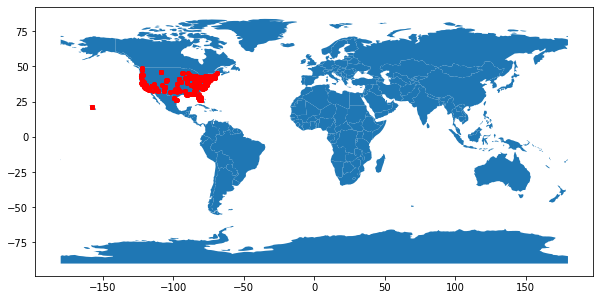

In [29]:
plotz = r.loc[~r['FOOD_INSECURE_HOUSE'].isin(['unknown', 'secure'])]
geometry = [Point(xy) for xy in zip(plotz['INTPTLONG'], plotz['INTPTLAT'])]
gdf = GeoDataFrame(plotz, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
dink = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

<AxesSubplot:xlabel='INTPTLONG', ylabel='INTPTLAT'>

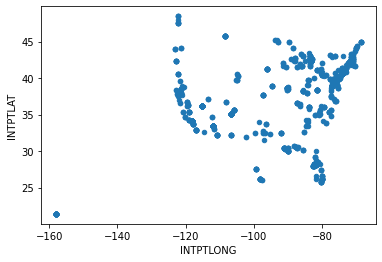

In [30]:
import matplotlib as plt

p = r.loc[~r['FOOD_INSECURE_HOUSE'].isin(['unknown', 'secure'])].reset_index()
p.plot(kind='scatter', x='INTPTLONG', y='INTPTLAT')

In [31]:
deserts = pd.read_csv('data/food_access_research_atlas.csv', dtype={'CensusTract': np.str})
deserts.drop(['TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN',
              'TractOMultir', 'TractHispanic'], inplace=True, axis=1)
deserts['FIPS_CODE'] = deserts['CensusTract'].str.slice(0, 5)
deserts.head()

<ipython-input-31-5feed39f2dcc>:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  deserts = pd.read_csv('data/food_access_research_atlas.csv', dtype={'CensusTract': np.str})


,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractHUNV,TractSNAP,FIPS_CODE
0,01001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,448,507,26,112,01001
1,01001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,0.0,0.0,0.0,0.0,0.0,763,606,87,202,01001
2,01001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,1578,894,108,120,01001
3,01001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,0.0,0.0,0.0,0.0,0.0,1241,1015,19,82,01001
4,01001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,0.0,0.0,0.0,0.0,0.0,2692,3162,198,488,01001


In [68]:
deserts.groupby('FIPS_CODE').agg('sum')
unfound = [n for n in list(deserts['FIPS_CODE'].unique()) if n not in fipses]
found_deserts = deserts.loc[~deserts.FIPS_CODE.isin(unfound)]
len(found_deserts)

72856

In [73]:
# arr = r['INTPTLONG','INTPTLAT']
# arr
r = r.reset_index(drop=True)
arr = r.loc[:][['INTPTLAT', 'INTPTLONG']]
arr['INTPTLAT'] = arr['INTPTLAT'].astype(np.float64)
arr['INTPTLONG'] = arr['INTPTLONG'].astype(np.float64)
arr.dtypes

INTPTLAT     float64
INTPTLONG    float64
dtype: object

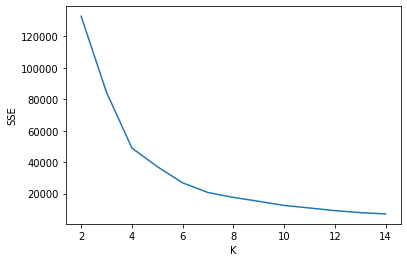

In [92]:
# from https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
def best_k(points, max_k: int = 15):
    return {k: KMeans(n_clusters=k).fit(points).inertia_ for k in range(2, max_k)}
errs = best_k(np.array(arr.to_numpy()))
plt.figure()
plt.plot(list(errs.keys()), list(errs.values()))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show() # shows '6' is optimal

#### The above shows that the optimal k is 6 or 7 - I'll choose 7 for the following

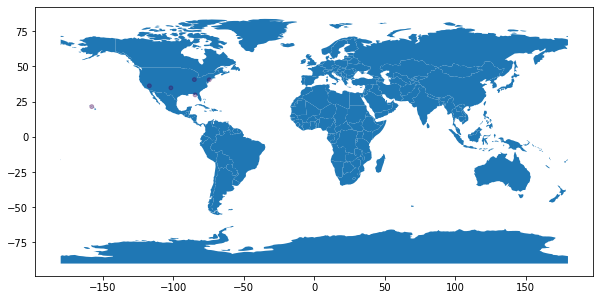

In [94]:
# plt.scatter(arr.INTPTLONG, arr.INTPTLAT, c=y, alpha=0.33333)

km = KMeans(n_clusters=6).fit(arr[['INTPTLONG', 'INTPTLAT']].to_numpy())
centroids = km.cluster_centers_
clust_geo = [Point(xy) for xy in centroids.tolist()]
gdf = GeoDataFrame(centroids, geometry=clust_geo)

clust_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
clusterplot = gdf.plot(ax=clust_world.plot(figsize=(10, 6)), marker='o', c=y, alpha=0.33333, markersize=15);